## Computer Vision
## Master in Machine Learning for Health

# LAB SESSION 6: IMAGE CLASSIFICATION WITH CNNs

# AUTOMATIC DIAGNOSTIC SYSTEM OF SKIN LESSIONS FROM DERMOSCOPIC IMAGES


### Iván González Díaz


<center><img src='http://www.tsc.uc3m.es/~igonzalez/images/logo_uc3m_foot.jpg' width=400 /></center>

In this practice we are going to build a skin lesion diagnosis system based on dermoscopic image analysis.

## Part 0: The problem

Before starting the practice, we will briefly describe the database that we will use and the problem we aim to address:

Our goal is to develop a CNN providing an automatic diagnosis of cutaneous diseases from dermoscopic images. Dermoscopy is a non-invasive technique that allows the evaluation of the colors and microstructures of the epidermis, the dermoepidermal joint and the papillary dermis that are not visible to the naked eye. These structures are specifically correlated with histological properties of the lesions. Identifying specific visual patterns related to color distribution or dermoscopic structures can help dermatologists decide the malignancy of a pigmented lesion. The use of this technique provides a great help to the experts to support their diagnosis. However, the complexity of its analysis limits its application to experienced clinicians or dermatologists.

In our scenario, we will consider 3 classes of skin lesions:

- Malignant melanoma: Melanoma, also known as malignant melanoma, is the most common type of cancer, and arises from pigmented cells known as melanocytes. Melanomas typically occur on the skin and rarely elsewhere such as the mouth, intestines, or eye.

- Seborrheic keratosis: it is a noncancerous (benign) tumor of the skin that originates from the cells of the outer layer of the skin (keranocytes), so it is a non-melanocytic lesion.

- Benign nevus: a benign skin tumor caused by melanocytes (it is melanocytic)

Figure 1 shows a visual example of the 3 considered lesions:

![Image of ISIC](https://www.tsc.uc3m.es/~igonzalez/images/ISIC.jpg)

The dataset has been obtained from the 'Internatial Skin Imaging Collaboration' (ISIC) file. It contains 2750 images divided into 3 sets:
- Training set: 2000 images
- Validation set: 150 images
- Test set: 600 images

For each clinical case, two images are available:
- The dermoscopic image of the lesion (in the ‘images’ folder).
- A binary mask with the segmentation between injury (mole) and skin (in the 'masks' folder)

Additionally, there is a csv file for each dataset (training, validation and test) in which each lines corresponds with a clinical case, defined with two fields separated by commas:
- the numerical id of the lesion: that allows to build the paths to the image and mask.
- the lesion label: available only for training and validation, being an integer between 0 and 2: 0: benign nevus, 1: malignant melanoma, 2: seborrheic keratosis. In the case of the test set, labels are not available (their value is -1).

Students will be able to use the training and validation sets to build their solutions and finally provide the scores associated with the test set. This practice provides a guideliness to build a baseline reference system. To do so, we will learn two fundamental procedures:

- 1) Process your own database with pytorch
- 2) Design a feedforward CNN that processess images and provides a diagnostic
- 2) Use a regular network that has been pretrained using a large-scale general purpose dataset and fine-tune it for our diagnostic problem

## Part 1: Handling our custom dataset with pytorch
Now we are going to study how we can load and process our custom dataset in pytorch. For that end, we are going to use the package ``scikit-image`` for reading images, and the package ``panda`` for reading csv files.


In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The first thing we need to do is to download and decompress the dataset on a local folder:




In [2]:
#ONLY TO USE GOOGLE COLAB. Run this code only the first time you run this notebook and then comment these lines
from shutil import copyfile
from google.colab import drive
import os, sys
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
copyfile('/content/drive/MyDrive/Computer Vision/Lab5/db1.zip', './db1.zip') #Copy db files to our working folder
copyfile('/content/drive/MyDrive/Computer Vision/Lab5/db2.zip', './db2.zip')

'./db2.zip'

In [4]:
#NOTE: Run this only once, in the machine where you want to run your code, then comment these lines
import zipfile
zipPath='./db1.zip' #path of the 1st zip file
dataFolder='./data' #We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)

zipPath='./db2.zip' #path of the 2nd zip file
dataFolder='./data' # We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)

Now let's read the indexed file and display data from image 65. The file structure is one row per image of the database, and two fields:
- Image ID (a 4-digit sequence, adding 0 to the left side if required)
- Label: 0 benign nevus, 1 melanoma, 2 seborrheic keratosis



In [5]:
db = pd.read_csv('data/dermoscopyDBtrain.csv',header=0,dtype={'id': str, 'label': int})

# We show inform
n = 65
img_id = db.id[65]
label = db.label[65]


print('Image ID: {}'.format(img_id))
print('Label: {}'.format(label))

Image ID: 0066
Label: 0


Now, let's create a simple function to show an image.




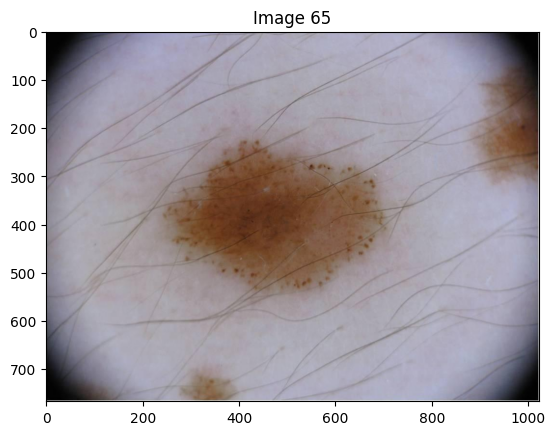

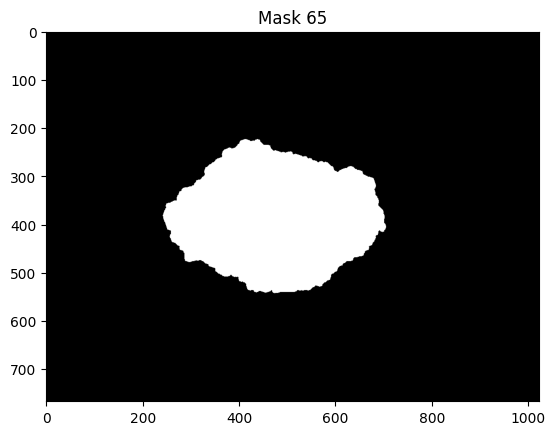

In [6]:
def imshow(image, title_str):
    if len(image.shape)>2:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap=plt.cm.gray)
    plt.title(title_str)

plt.figure()
imshow(io.imread(os.path.join('data/images/', img_id + '.jpg' )),'Image %d'%n)
plt.figure()
imshow(io.imread(os.path.join('data/masks/', img_id + '.png')),'Mask %d'%n)

plt.show()

### Class Dataset

The class `` torch.utils.data.Dataset`` is an abstract class that represents a dataset.

To create our custom dataset in pytorch we must inherit from this class and overwrite the following methods:

- `` __len__`` so that `` len (dataset) `` returns the size of the dataset.
- `` __getitem__`` to support indexing `` dataset [i] `` when referring to sample $i$

We are going to create the train and test datasets of our diagnostic problem. We will read the csv in the initialization method `` __init__`` but we will leave the explicit reading of the images for the method
`` __getitem__``. This approach is more efficient in memory because all the images are not loaded in memory at first, but are read individually when necessary.

Our dataset is going to be a dictionary `` {'image': image, 'mask': mask, 'label': label} ``. You can also take an optional `` transform '' argument so that we can add pre-processing and data augmentation techniques.



In [7]:
class DermoscopyDataset(Dataset):
    """Dermoscopy dataset."""

    def __init__(self, csv_file, root_dir,transform=None,  maxSize=0):
        """
        Args:
            csv_file (string): Path al fichero csv con las anotaciones.
            root_dir (string): Directorio raíz donde encontraremos las carpetas 'images' y 'masks' .
            transform (callable, optional): Transformaciones opcionales a realizar sobre las imágenes.
        """
        self.dataset = pd.read_csv(csv_file,header=0,dtype={'id': str, 'label': int})

        if maxSize>0:
            newDatasetSize=maxSize #maxSize muestras
            idx=np.random.RandomState(seed=42).permutation(range(len(self.dataset)))
            reduced_dataset=self.dataset.iloc[idx[0:newDatasetSize]]
            self.dataset=reduced_dataset.reset_index(drop=True)

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir,'images')
        self.mask_dir = os.path.join(root_dir,'masks')
        self.transform = transform
        self.classes = ['nevus', 'melanoma', 'keratosis']
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Leemos la imagen
        img_name = os.path.join(self.img_dir,self.dataset.id[idx] + '.jpg')
        image = io.imread(img_name)
        #Leemos la máscara
        mask_name = os.path.join(self.mask_dir,self.dataset.id[idx] + '.png')
        mask = io.imread(mask_name)

        sample = {'image': image, 'mask': mask, 'label':  self.dataset.label[idx].astype(dtype=np.int64)}
        if self.transform:
            sample = self.transform(sample)
        return sample

**IMPORTANT**

The optional parameter ``maxSize`` in the constructor allows us to subsample the number of images and consequently reduce the size of the dataset. If not set included or maxSize=0, then the dataset will include all the images. This parameter is useful to train models over smaller datasets during hyperparameter validation and design phases. Working with less images reduces the training time at the expense of obtaining results that may deviate from those obtained with the full dataset size. Of course, the larger the training dataset, the more stable results but the larger the training time. Hence, it is up to the students the use of this parameter.

### Data pre-processing and Augmentation: Transforms
----------

In the previously shown examples we can see that the size of the images is not the same. This would prevent to train a red convolutional neuronal, as the vast majority require fixed-size inputs. Furthermore, the image is not always adjusted to the lesion, and indeed, in some examples lesions are very small compared to the size of the image. It would then be desirable to adjust the input images so that the lesion covers almost the entire image.

To do this, we are going to create some preprocessing code, focusing on 5 transformations:

- ``CropByMask``: to crop the image using the lesion mask
- ``Rescale``: to scale the image
- ``RandomCrop``: to crop the image randomly, it allows us to augment the data samples with random crops
- ``CenterCrop``: to perform a central crop of the image with the indicated size (useful in test)
- ``ToTensor``: to convert numpy matrices into torch tensors (rearranging the axes).

We will define them as callable classes instead of simple functions, as we will not need to pass the transform  parameters every time we call a method. To do this, we only have to implement the `` __call__`` method and, if necessary, the `` __init__`` method.
Then we can use a transformation with the following code:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)


In [8]:
class CropByMask(object):
    """Crop the image using the lesion mask.

    Args:
        border (tuple or int): Border surrounding the mask. We dilate the mask as the skin surrounding
        the lesion is important for dermatologists.
        If it is a tuple, then it is (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        #Compute the coordinates of the bounding box that contains the mask
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Crop the image
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return {'image': image, 'mask': mask, 'label' : label}

class Rescale(object):
    """Re-scale image to a predefined size.

    Args:
        output_size (tuple or int): The desired size. If it is a tuple, output is the output_size.
        If it is an int, the smallest dimension will be the output_size
            a we will keep fixed the original aspect ratio.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))

        return {'image': img, 'mask': msk, 'label' : label}

class RandomCrop(object):
    """Randomly crop the image.

    Args:
        output_size (tuple or int): Crop size. If  int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if h>new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top=0

        if w>new_w:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}

class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w

        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0

        if w>new_w:
            left = int(rem_w/2)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}


class ToTensor(object):
    """Convert ndarrays into pytorch tensors."""

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        # Cambiamos los ejes
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        # A la máscara le añadimos una dim fake al principio
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)
        label=torch.tensor(label,dtype=torch.long)

        return {'image':image,
                'mask':mask,
                'label':label}

class Normalize(object):
    """Normalize data by subtracting means and dividing by standard deviations.

    Args:
        mean_vec: Vector with means.
        std_vec: Vector with standard deviations.
    """

    def __init__(self, mean,std):

        assert len(mean)==len(std),'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        c, h, w = image.shape
        assert c==len(self.mean), 'Length of mean and image is not the same'
        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        image.sub_(mean[:, None, None]).div_(std[:, None, None])


        return {'image': image, 'mask': mask, 'label' : label}

#### Using package torchvision.transforms

Package torchvision.trasforms comes with many useful methods that implement valuable transforms for data augmentation. Those transforms can be applied either to torch.tensors or to images. However, torchvision uses PIL library to read and process images, in contrast to the matrix representation of images used in scikit-image library (the library we have used in the previous methods). Furthermore, some of the transforms affect both to input images and skin-lesion masks, which avoid applying them to our samples. Hence, in order to use a torchvision transform we need to implement a pipeline that:

- 1) First, convert the matrix-based images to PILImages
- 2) Apply the transform to PILImages
- 3) Convert PILImages to matrices

And applies these to input images and, if necessary, to the binary skin-lesion masks. The following class ``TVCenterCrop`` implements the same functionality as the previous ``CenterCrop``, but using the corresponding method in torchvision. It is therefore a useful example if you plan to make use of torchvision transforms.


In [9]:
class TVCenterCrop(object):
    """Crop the central area of the image. Example using the method in torchvision. Requires to
    internally convert from skimage (numpy array) to PIL Image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, size):
        self.CC=transforms.CenterCrop(size)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image=self.CC(pil_image)
        image=util.img_as_float(np.asarray(pil_image))

        pil_mask=Image.fromarray(util.img_as_ubyte(mask))
        pil_mask=self.CC(pil_mask)
        mask=util.img_as_float(np.asarray(pil_mask))

        return {'image': image, 'mask': mask, 'label': label}

## Part 3: Train and evaluate our CNN

In the third part of the practice we are going to build a first automatic system for the diagnosis of skin lesions based on the network that we have created in the previous section. To train and evaluate the network, we need to define several elements, such as the performance metric, the loss function, the optimizer or the learning rate strategy. In the next sections we will configure these elements.

### Performance Metric for evaluation
We will start by defining the metric we will use to evaluate our network. In particular, and following the instructions of the organizers of the original ISIC challenge, we will use the area under the ROC or AUC (https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

AUC is a metric that avoids setting a specific threshold to make detections and is applied over the soft outputs of a **binary** classifier. By modifying the value of the threshold, we can build a ROC curve setting the False Positive Rate (FPR) in the y-axis and the True Positive Rate (TPR) in the x-axis. TPR is the proportion of positive cases than have been succesfully detected, whereas FPR is the number of false detections divided by the number of negatives.

For low detection thresholds and an imperfect system, TPR will be high at the expense of a high FPR (as the system always says 1). For high threholds, the opposite situation happens. Once the ROC is built, the AUC measures the integral behind the curve, which is in the range [0,1].

Although, at least theoretically, AUC can be lower than 0.5, in partice, the output of a baseline system that randomly decides 0 or 1 with equal probability obtains an AUC=0.5, so lower values are usually caused by bugs in the code (and could be avoided just by inverting the outputs of the system).

The following figure shows some examples of AUC and ROC curves:


<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png' width=384 /></center>

As we have mentioned, AUC is a metric to evaluate binary problems (labels 0,1), and has the advantage of being independent of the detection threshold. It also behaves well against unbalanced problems, as it evaluates the ranking of the scores (their order with respect to the labels) and not their absolute values.

Since our problem is multiclass, we will calculate 3 different AUCs:
- 1) AUC of binary problem melanoma vs all
- 2) AUC of the binary problem seborrheic keratosis vs all
- 3) AUC average of the previous two

The following function computes AUCs from the complete database outputs:



In [10]:
#Function that computes 2 AUCs: melanoma vs all and keratosis vs all
# scores is nx3: n is the number of samples in the dataset
# labels is nx1
# Function resturns an array with two elements: the auc values
def computeAUCs(scores, labels):

    aucs = np.zeros((2,))
    #Calculamos el AUC melanoma vs all
    scores_mel = scores[:,1]
    labels_mel = (labels == 1).astype(np.int64)
    aucs[0]=metrics.roc_auc_score(labels_mel, scores_mel)

    #Calculamos el AUC queratosis vs all
    scores_sk = scores[:,2]
    labels_sk = (labels == 2).astype(np.int64)
    aucs[1]=metrics.roc_auc_score(labels_sk, scores_sk)

    return aucs

## Part 5: Evaluation (Important)
The evaluation of this practice will be done through a challenge, for which the students will have to send the results based on the test data in two categories:

- 1) CUSTOM Category: The results on the test set of a custom network, created from scratch by the students. In this case, the complete code of the network must appear in cells of the notebook and it will not be possible to make use of external networks/packages or pre-trained models.

- 2) FINE-TUNING Category: The results on the test set of a network that has been previously initialized in another database (with fine-tuning). In this case, existing models in torchvision or even external networks can be used.

In addition, the final mark will depend both on the results in both categories and on the content of a brief report (1 side for the description, 1 side for extra material: tables, figures and references) where they will describe the most important aspects of the proposed solutions. The objective of this report is for the teacher to assess the developments/extensions/decisions made by the students when optimizing their system. You do not need to provide an absolute level of detail about the changes made, just list them and briefly discuss the purpose of the changes.

### Details of the material to send for evaluation:

One zip file will be uploaded per group with the following contents:

- Two .csv files with the test outputs of the models that have trained in the two categories. Each file will contain a matrix of size 600x3, 600 lesions and the 3 classes considered in the problem. The array should be provided in csv format (with 3 numbers per row separated by ','). Code to generate the outputs is provided later.

- The report as described above.

- The notebook that integrates the creation of both models so that the teacher can check how things have been implemented.

The deadline for delivery of the practice is Sunday May 12 at 23:59.



Next we provide some functions that allow to test the network and create the csv file with the outputs.


### **Dataset**

Add a random rotation pipe for training

In [11]:
# Pixel means and stds expected by models in torchvision
pixel_mean=[0.485, 0.456, 0.406]
pixel_std=[0.229, 0.224, 0.225]

# Train Dataset
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data',
                                    maxSize=0, ###IMPORTANT
                                    transform=transforms.Compose([
                                    CropByMask(30),
                                    Rescale(224),
                                    CenterCrop(224),
                                    transforms.RandomRotation(degrees=[0, 90, 180, 270]),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean, std=pixel_std)
                                    ]))
# Val dataset
val_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBval.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(30),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean, std=pixel_std)
                                    ]))

# Test dataset
test_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtest.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(30),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean, std=pixel_std)
                                    ]))

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) tensor(0)
1 torch.Size([3, 224, 224]) tensor(0)
2 torch.Size([3, 224, 224]) tensor(1)
3 torch.Size([3, 224, 224]) tensor(0)


Analyze class imabalence to compute class weights

In [24]:
labels = [train_dataset[i]['label'] for i in range(len(train_dataset))]
labels, counts = np.unique(labels, return_counts=True)

for label, count in zip(labels, counts):
  print(f"Class {label} - {count} samples")

Class 0 - 1372 samples
Class 1 - 374 samples
Class 2 - 254 samples


Finally we compute the inverse frequency weights for each class

In [27]:
weights = len(train_dataset) / counts
print(weights)

[1.45772595 5.34759358 7.87401575]


Create dataloaders

0 torch.Size([64, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2,
        2, 1, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0])


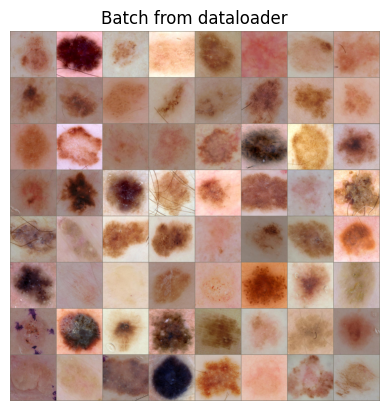

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)

#Validation dataset => No shuffle
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

#Test Dataset => => No shuffle
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=3)

# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Mostramos las lesiones de un batch."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    #Generamos el grid
    grid = utils.make_grid(images_batch)
    #Lo pasamos a numpy y lo desnormalizamos
    grid=grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()

    #We show the data of the 3rd batch and stop.
    if i_batch == 0:
        break

### **Custom CNN**

In [13]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [51]:
class CNNBase(nn.Module):
  def __init__(self, input_dim, kernels1, kernels2, kernels3, kernels4, kernels5, kernel_size, num_classes, p):
    super().__init__()

    # Params
    self.input_dim = input_dim
    self.kernel_size = kernel_size
    self.kernels1 = kernels1
    self.kernels2 = kernels2
    self.kernels3 = kernels3
    self.kernels4 = kernels4
    self.kernels5 = kernels5
    self.num_classes = num_classes
    self.p = p

    # Final dimension
    self.out_conv1 = int(1 + (self.input_dim - self.kernel_size)) / 2
    self.out_conv2 = int(1 + (self.out_conv1 - self.kernel_size)) / 2
    self.out_conv3 = int(1 + (self.out_conv2 - self.kernel_size)) / 2
    self.out_conv4 = int(1 + (self.out_conv3 - self.kernel_size)) / 2
    self.out_conv5 = int(1 + (self.out_conv4 - self.kernel_size)) / 2
    self.final_dim = int(np.ceil(self.kernels5 * self.out_conv5**2))

    # Conv. Layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.kernels1, kernel_size=self.kernel_size, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=self.kernels1, out_channels=self.kernels2, kernel_size=self.kernel_size, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=self.kernels2, out_channels=self.kernels3, kernel_size=self.kernel_size, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=self.kernels3, out_channels=self.kernels3, kernel_size=self.kernel_size, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=self.kernels4, out_channels=self.kernels5, kernel_size=self.kernel_size, stride=1, padding=0)

    # Batch Norm
    self.bn1 = nn.BatchNorm2d(self.kernels1)
    self.bn2 = nn.BatchNorm2d(self.kernels2)
    self.bn3 = nn.BatchNorm2d(self.kernels3)
    self.bn4 = nn.BatchNorm2d(self.kernels4)
    self.bn5 = nn.BatchNorm2d(self.kernels5)

    # Linear Layers
    self.fc1 = nn.Linear(self.final_dim, self.num_classes)

    # Pooling
    self.pool = nn.MaxPool2d(2, 2)

    # Dropout
    self.dropout2d = nn.Dropout2d(p=self.p)

    # Last layer
    self.logsoftmax = nn.LogSoftmax(dim=1)

    # Activation
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.dropout2d(self.relu(self.bn1(self.conv1(x))))
    x = self.pool(x)
    x = self.dropout2d(self.relu(self.bn2(self.conv2(x))))
    x = self.pool(x)
    x = self.dropout2d(self.relu(self.bn3(self.conv3(x))))
    x = self.pool(x)
    x = self.dropout2d(self.relu(self.bn4(self.conv4(x))))
    x = self.pool(x)
    x = self.dropout2d(self.relu(self.bn5(self.conv5(x))))
    x = self.pool(x)
    # Flatten for linear layers
    x = x.view(x.shape[0], -1)
    # Linear layers
    x = self.logsoftmax(self.fc1(x))

    return x

In [52]:
class CNN(CNNBase):
  def __init__(self, input_dim, kernels1, kernels2, kernels3, kernels4, kernels5, kernel_size, num_classes, p, lr,
               saving_path, load_best_model=True, metric_for_best_model='auc', class_weights=None):
    super().__init__(input_dim, kernels1, kernels2, kernels3, kernels4, kernels5, kernel_size, num_classes, p)

    # Parameters
    self.lr = lr
    self.optim = optim.Adam(self.parameters(), lr=self.lr)

    if class_weights is not None:
      self.criterion = nn.NLLLoss(weight=torch.Tensor(class_weights))
    else:
      self.criterion = nn.NLLLoss()

    self.early_stopper = EarlyStopper(patience=5, min_delta=0)
    self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optim, mode='min', factor=0.1, patience=2, verbose=True)

    self.saving_path = saving_path
    self.load_best_model = load_best_model
    self.metric_for_best_model = metric_for_best_model

    # Save results
    self.loss_during_training = []
    self.valid_loss_during_training = []
    self.train_auc_sk_during_training = []
    self.train_auc_mel_during_training = []
    self.valid_auc_sk_during_training = []
    self.valid_auc_mel_during_training = []
    self.mean_valid_auc = []
    self.mean_train_auc = []

    # GPU
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(self.device)

  def __call__(self, x):
    x = self.forward(x)
    probs = torch.exp(x)
    return probs

  def trainloop(self, trainloader, validloader, epochs, print_every):
    self.epochs = epochs

    for e in range(epochs):
      training_loss = 0
      valid_loss = 0
      outputs_m = []
      labels_m = []

      # Training
      self.train()
      for data in trainloader:
        images = data['image']
        labels = data['label']
        images = images.to(self.device)
        labels = labels.to(self.device)
        self.optim.zero_grad()
        out = self.forward(images.float())
        loss = self.criterion(out, labels.view(-1))
        training_loss += loss.item()
        loss.backward()
        self.optim.step()

        # AUCs
        outputs_m.append(out.cpu().detach().numpy())
        labels_m.append(labels.cpu().detach().numpy())

      # Train AUCs
      outputs_m = np.vstack(outputs_m)
      labels_m = np.concatenate(labels_m)
      train_auc_mel, train_auc_sk = computeAUCs(np.exp(outputs_m), labels_m)
      train_mean_auc = (train_auc_mel + train_auc_sk) / 2

      self.loss_during_training.append(training_loss / len(trainloader))
      self.train_auc_mel_during_training.append(train_auc_mel)
      self.train_auc_sk_during_training.append(train_auc_sk)
      self.mean_train_auc.append(train_mean_auc)

      outputs_m = []
      labels_m = []

      # Validation
      self.eval()
      with torch.no_grad():
        for data in validloader:
          images = data['image']
          labels = data['label']
          images = images.to(self.device)
          labels = labels.to(self.device)
          out = self.forward(images.float())
          loss = self.criterion(out, labels.view(-1))
          valid_loss += loss.item()

          # AUCs
          outputs_m.append(out.cpu().detach().numpy())
          labels_m.append(labels.cpu().detach().numpy())

      # Validation AUC
      outputs_m = np.vstack(outputs_m)
      labels_m = np.concatenate(labels_m)
      valid_auc_mel, valid_auc_sk = computeAUCs(np.exp(outputs_m), labels_m)
      valid_mean_auc = (valid_auc_mel + valid_auc_sk) / 2

      self.valid_loss_during_training.append(valid_loss / len(validloader))
      self.valid_auc_mel_during_training.append(valid_auc_mel)
      self.valid_auc_sk_during_training.append(valid_auc_sk)
      self.mean_valid_auc.append(valid_mean_auc)

      # LR scheduler
      self.scheduler.step(self.loss_during_training[-1])

      # Early Stopping
      if self.early_stopper.early_stop(self.valid_loss_during_training[-1]) and e != 0:
        print(f" - early stopping at epoch {e}...")
        self.epochs = e + 1
        break

      # Print
      if e % print_every == 0 or e + 1 == epochs:
        print(f"epoch {e} - training loss {training_loss/len(trainloader)} - validation loss {valid_loss/len(validloader)}")
        print(f"\ttrain AUC (MEL, SK) {self.train_auc_mel_during_training[-1]:.3f} {self.train_auc_sk_during_training[-1]:.3f}")
        print(f"\tvalidation AUC (MEL, SK) {self.valid_auc_mel_during_training[-1]:.3f} {self.valid_auc_sk_during_training[-1]:.3f}")

      # Saving checkpoint
      if self.load_best_model:
        torch.save(self.state_dict(), self.saving_path + f"/checkpoint_{e}")

    # Load best model at end
    if self.load_best_model:
      best_epoch_dict = {'auc':  np.argmax(self.mean_valid_auc),
                         'loss': np.argmin(self.valid_loss_during_training)}
      self.load_state_dict(torch.load(self.saving_path + f'/checkpoint_{best_epoch_dict[self.metric_for_best_model]}'))

  def plot_learning_curves(self, axes):
    # Learning curves
    axes[0].plot(range(self.epochs - 1), self.loss_during_training[1:], label='Training Loss')
    axes[0].plot(range(self.epochs - 1), self.valid_loss_during_training[1:], label='Validation Loss')
    axes[0].legend(loc='best')
    axes[0].grid()

    # MEL and SK AUCs
    axes[1].plot(range(self.epochs - 1), self.train_auc_mel_during_training[1:], label='Training MEL AUC')
    axes[1].plot(range(self.epochs - 1), self.train_auc_sk_during_training[1:], label='Training SK AUC')
    axes[1].plot(range(self.epochs - 1), self.valid_auc_mel_during_training[1:], label='Validation MEL AUC')
    axes[1].plot(range(self.epochs - 1), self.valid_auc_sk_during_training[1:], label='Validation SK AUC')
    axes[1].legend(loc='best')
    axes[1].grid()

    # Mean AUC
    axes[2].plot(range(self.epochs - 1), self.mean_train_auc[1:], label='Training AUC')
    axes[2].plot(range(self.epochs - 1), self.mean_valid_auc[1:], label='Validation AUC')
    axes[2].legend(loc='best')
    axes[2].grid()

Training

In [53]:
# Instantiate CNN
path = '/content/drive/MyDrive/Computer Vision/Lab5/checkpoints_custom'
custom_cnn = CNN(input_dim=224, kernels1=8, kernels2=8, kernels3=16, kernels4=16, kernels5=32, kernel_size=3, num_classes=3, p=0.2, lr=1e-3,
                 saving_path=path, load_best_model=True, metric_for_best_model='auc', class_weights=weights)

# Training CNN
custom_cnn.trainloop(train_dataloader, val_dataloader, epochs=25, print_every=1)

epoch 0 - training loss 1.1661946587264538 - validation loss 1.0682207345962524
	train AUC (MEL, SK) 0.485 0.545
	validation AUC (MEL, SK) 0.733 0.752


KeyboardInterrupt: 

In [ ]:
# custom_cnn.load('')

Plot learning curves to identify trends

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
custom_cnn.plot_learning_curves(axes)
plt.show()

Save model

In [ ]:
path = '/content/drive/MyDrive/Computer Vision/Lab5/'
torch.save(custom_cnn.state_dict(), path + '/custom_cnn.pth')

### **Fine Tuned CNN**

In [50]:
class PretrainedCNN(nn.Module):
  def __init__(self, model, lr, saving_path, load_best_model=True, metric_for_best_model='auc', class_weights=None):
    super().__init__()
    self.model = model

    # Adapt classification head
    self.num_features = self.model.fc.in_features
    self.model.fc = nn.Linear(self.num_features, 3)

    # Training args
    self.lr = lr
    self.optim = optim.Adam(self.model.parameters(), lr=self.lr)

    if class_weights is not None:
      self.criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights))
    else:
      self.criterion = nn.CrossEntropyLoss()

    self.early_stopper = EarlyStopper(patience=3, min_delta=0)
    self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optim, mode='min', factor=0.1, patience=2, verbose=True)

    # Parameters
    self.saving_path = saving_path
    self.load_best_model = load_best_model
    self.metric_for_best_model = metric_for_best_model

    # Save results
    self.loss_during_training = []
    self.valid_loss_during_training = []
    self.train_auc_sk_during_training = []
    self.train_auc_mel_during_training = []
    self.valid_auc_sk_during_training = []
    self.valid_auc_mel_during_training = []
    self.mean_valid_auc = []
    self.mean_train_auc = []

    # GPU
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(self.device)

  def __call__(self, x):
      return self.model(x)

  def trainloop(self, trainloader, validloader, epochs, print_every):
    self.epochs = epochs

    for e in range(epochs):
      training_loss = 0
      valid_loss = 0
      outputs_m = []
      labels_m = []

      # Training
      self.train()
      for data in trainloader:
        images = data['image']
        labels = data['label']
        images = images.to(self.device)
        labels = labels.to(self.device)
        self.optim.zero_grad()
        out = self.model(images.float())
        loss = self.criterion(out, labels.view(-1))
        training_loss += loss.item()
        loss.backward()
        self.optim.step()

        # AUCs
        outputs_m.append(out.cpu().detach().numpy())
        labels_m.append(labels.cpu().detach().numpy())

      # Train AUCs
      outputs_m = np.vstack(outputs_m)
      labels_m = np.concatenate(labels_m)
      train_auc_mel, train_auc_sk = computeAUCs(np.exp(outputs_m), labels_m)
      train_mean_auc = (train_auc_mel + train_auc_sk) / 2

      self.loss_during_training.append(training_loss / len(trainloader))
      self.train_auc_mel_during_training.append(train_auc_mel)
      self.train_auc_sk_during_training.append(train_auc_sk)
      self.mean_train_auc.append(train_mean_auc)

      outputs_m = []
      labels_m = []

      # Validation
      self.eval()
      with torch.no_grad():
        for data in validloader:
          images = data['image']
          labels = data['label']
          images = images.to(self.device)
          labels = labels.to(self.device)
          out = self.model(images.float())
          loss = self.criterion(out, labels.view(-1))
          valid_loss += loss.item()

          # AUCs
          outputs_m.append(out.cpu().detach().numpy())
          labels_m.append(labels.cpu().detach().numpy())

      # Validation AUC
      outputs_m = np.vstack(outputs_m)
      labels_m = np.concatenate(labels_m)
      valid_auc_mel, valid_auc_sk = computeAUCs(np.exp(outputs_m), labels_m)
      valid_mean_auc = (valid_auc_mel + valid_auc_sk) / 2

      self.valid_loss_during_training.append(valid_loss / len(validloader))
      self.valid_auc_mel_during_training.append(valid_auc_mel)
      self.valid_auc_sk_during_training.append(valid_auc_sk)
      self.mean_valid_auc.append(valid_mean_auc)

      # LR scheduler
      self.scheduler.step(self.loss_during_training[-1])

      # Early Stopping
      if self.early_stopper.early_stop(self.valid_loss_during_training[-1]) and e != 0: # Avoid early stopping at first epoch
        print(f" - early stopping at epoch {e}...")
        self.epochs = e + 1
        break

      # Print
      if e % print_every == 0 or e + 1 == epochs:
        print(f"epoch {e} - training loss {training_loss/len(trainloader)} - validation loss {valid_loss/len(validloader)}")
        print(f"\ttrain AUC (MEL, SK) {self.train_auc_mel_during_training[-1]:.3f} {self.train_auc_sk_during_training[-1]:.3f}")
        print(f"\tvalidation AUC (MEL, SK) {self.valid_auc_mel_during_training[-1]:.3f} {self.valid_auc_sk_during_training[-1]:.3f}")

      # Saving checkpoint
      if self.load_best_model:
        torch.save(self.state_dict(), self.saving_path + f"/checkpoint_{e}")

    # Load best model at end
    if self.load_best_model:
      best_epoch_dict = {'auc':  np.argmax(self.mean_valid_auc),
                         'loss': np.argmin(self.valid_loss_during_training)}
      self.load_state_dict(torch.load(self.saving_path + f'/checkpoint_{best_epoch_dict[self.metric_for_best_model]}'))

  def plot_learning_curves(self, axes):
    # Learning curves
    axes[0].plot(range(self.epochs - 1), self.loss_during_training[1:], label='Training Loss')
    axes[0].plot(range(self.epochs - 1), self.valid_loss_during_training[1:], label='Validation Loss')
    axes[0].legend(loc='best')
    axes[0].grid()

    # MEL and SK AUCs
    axes[1].plot(range(self.epochs - 1), self.train_auc_mel_during_training[1:], label='Training MEL AUC')
    axes[1].plot(range(self.epochs - 1), self.train_auc_sk_during_training[1:], label='Training SK AUC')
    axes[1].plot(range(self.epochs - 1), self.valid_auc_mel_during_training[1:], label='Validation MEL AUC')
    axes[1].plot(range(self.epochs - 1), self.valid_auc_sk_during_training[1:], label='Validation SK AUC')
    axes[1].legend(loc='best')
    axes[1].grid()

    # Mean AUC
    axes[2].plot(range(self.epochs - 1), self.mean_train_auc[1:], label='Training AUC')
    axes[2].plot(range(self.epochs - 1), self.mean_valid_auc[1:], label='Validation AUC')
    axes[2].legend(loc='best')
    axes[2].grid()

Training

In [49]:
# Instantiate CNN
path = '/content/drive/MyDrive/Computer Vision/Lab5/checkpoints_ft'

model = models.resnet50(pretrained=True)
# model = models.inception_v3(pretrained=True)
# model = models.densenet121(pretrained=True)
pretrained_cnn = PretrainedCNN(model, lr=1e-4, saving_path=path, load_best_model=True, metric_for_best_model='auc', class_weights=weights)

# Training CNN
pretrained_cnn.trainloop(train_dataloader, val_dataloader, epochs=25, print_every=2)

epoch 0 - training loss 0.7633968386799097 - validation loss 0.594186027844747
	train AUC (MEL, SK) 0.748 0.890
	validation AUC (MEL, SK) 0.839 0.955
epoch 2 - training loss 0.09255616078735329 - validation loss 1.1421812574068706
	train AUC (MEL, SK) 0.996 0.999
	validation AUC (MEL, SK) 0.821 0.940
epoch 4 - training loss 0.07180912682088092 - validation loss 1.0361605087916057
	train AUC (MEL, SK) 0.995 1.000
	validation AUC (MEL, SK) 0.813 0.954


KeyboardInterrupt: 

In [ ]:
custom_cnn.load('')

Plot learning curves to identify trends

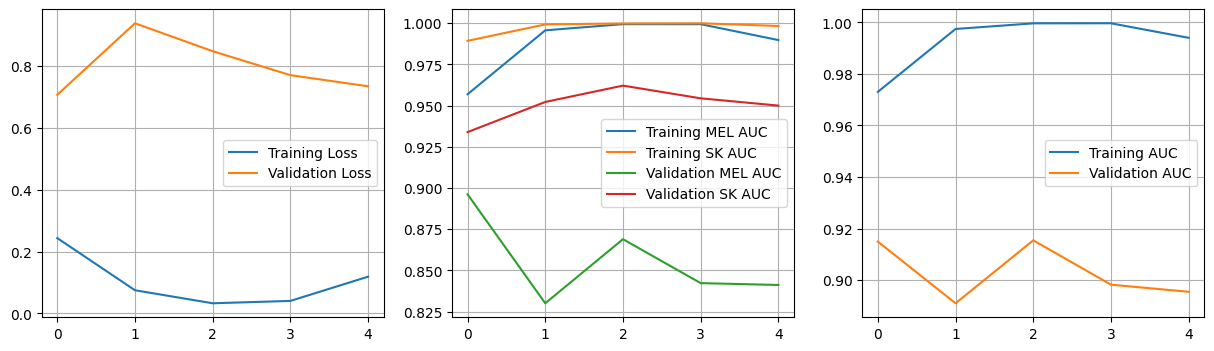

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
pretrained_cnn.plot_learning_curves(axes)
plt.show()

Save model

In [ ]:
path = '/content/drive/MyDrive/Computer Vision/Lab5'
torch.save(pretrained_cnn.state_dict(), path + '/resnet50_ft_2.pth')

### **Test Scores**

In [ ]:
### Code that generates the test matrix
def test_model(model, apply_softmax=True):
    since = time.time()

    numClasses = len(test_dataset.classes)

    model.eval()   # Ponemos el modelo en modo evaluación

    #Tamaño del dataset
    numSamples = len(test_dataset)

    # Creamos las variables que almacenarán las salidas y las etiquetas
    outputs_m=np.zeros((numSamples,numClasses),dtype=np.float64)
    labels_m=np.zeros((numSamples,),dtype=np.int64)
    contSamples=0

    # Iteramos sobre los datos
    for sample in test_dataloader:
        inputs = sample['image'].to(device).float()

        #Tamaño del batch
        batchSize = inputs.shape[0]

        # Paso forward
        with torch.torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            #Aplicamos un softmax a la salida
            if apply_softmax:
              outputs=F.softmax(outputs.data,dim=1)
            outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
            contSamples+=batchSize


    return outputs_m

Running the previous function and obtaining the matrix with the scores (Nx3)

In [ ]:
# outputs_custom=test_model(custom_cnn, softmax=False)
outputs_ft=test_model(pretrained_cnn)

And finally save the matrix into a csv file

In [ ]:
import csv

# with open('/content/drive/MyDrive/Computer Vision/Lab5/output_test_custom.csv', mode='w') as out_file:
#     csv_writer = csv.writer(out_file, delimiter=',')
#     csv_writer.writerows(outputs_custom);

with open('/content/drive/MyDrive/Computer Vision/Lab5/output_test_resnet50_2.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerows(outputs_ft);